In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set_style('whitegrid')
from bs4 import BeautifulSoup, SoupStrainer
import sys, string, requests, datetime, time
%matplotlib inline

Preview table:

In [5]:
players = pd.read_csv('Tables/players.csv') # this csv file is taken from web scraped data from Baskeball-Reference
players.head()

,name,active_from,active_to,career_length,birth_date,position,trad_position,ppg,trb,ast,...,ws,height_inches,weight,shooting_hand,hof,college,hs_name,hs_city,hs_state,url
0,Alaa Abdelnaby,1991,1995,4,1968-06-24,Power Forward,Forward,5.7,3.3,0.3,...,4.8,82.0,240.0,Right,0.0,Duke University,Bloomfield,Bloomfield,New Jersey,/players/a/abdelal01.html
1,Zaid Abdul-Aziz,1969,1978,9,1946-04-07,Power Forward,Forward,9.0,8.0,1.2,...,17.5,81.0,235.0,Right,0.0,Iowa State University,John Jay,Brooklyn,New York,/players/a/abdulza01.html
2,Kareem Abdul-Jabbar,1970,1989,19,1947-04-16,Center,Center,24.6,11.2,3.6,...,273.4,86.0,225.0,Right,1.0,"University of California, Los Angeles",Power Memorial,New York,New York,/players/a/abdulka01.html
3,Mahmoud Abdul-Rauf,1991,2001,10,1969-03-09,Point Guard,Guard,14.6,1.9,3.5,...,25.2,73.0,162.0,Right,0.0,Louisiana State University,Gulfport,Gulfport,Mississippi,/players/a/abdulma02.html
4,Tariq Abdul-Wahad,1998,2003,5,1974-11-03,Shooting Guard,Guard,7.8,3.3,1.1,...,3.5,78.0,223.0,Right,0.0,"University of Michigan, San Jose State University",Lycee Aristide Briand,Evreux,France,/players/a/abdulta01.html


In [6]:
#hof_not_eligible = players[players['active_to'] > 2015]
players_hof = players[players['hof'] == 1.0]
players_not_hof = players[players['hof'] == 0]

## Data visualization

### Individual statistics

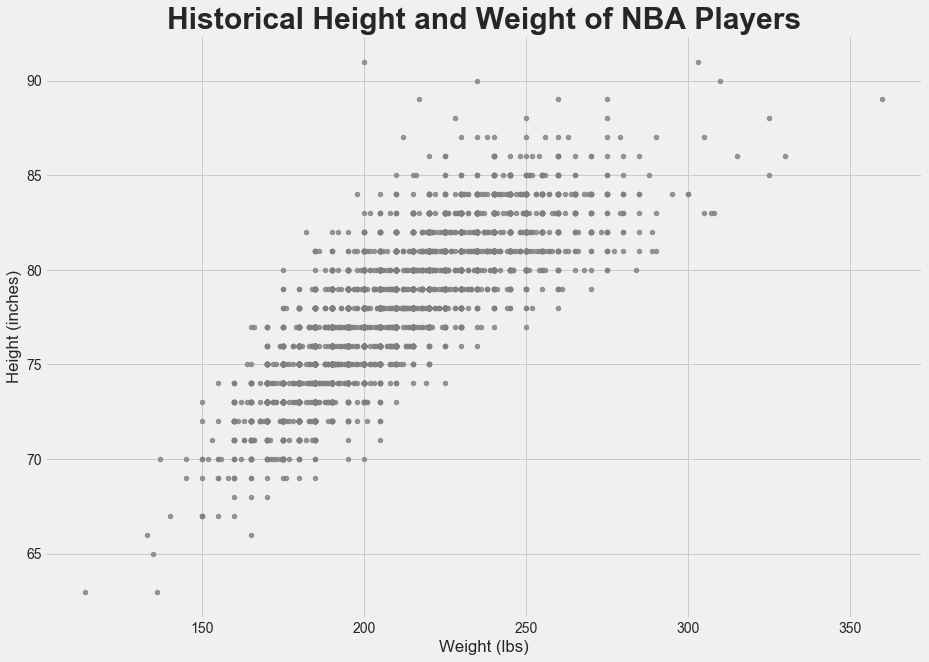

In [7]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,10))

ax = sns.regplot(x='weight', y='height_inches', data=players, 
                 color='grey', fit_reg=False, scatter_kws={"s": 20})

ax.set(xlabel='Weight (lbs)', ylabel='Height (inches)')
plt.title('Historical Height and Weight of NBA Players', fontsize=30, fontweight="bold")

plt.savefig('all-graphs/height_weight.png')

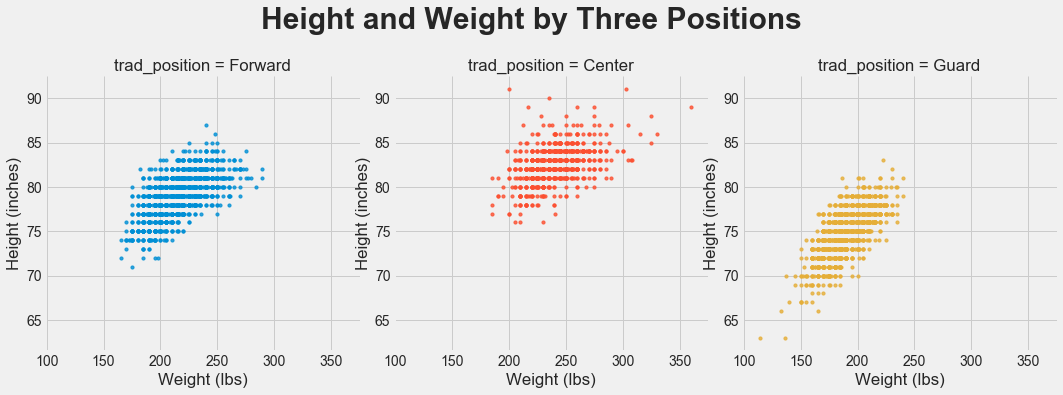

In [8]:
plt.style.use('fivethirtyeight')

ax = sns.lmplot(x="weight", y="height_inches", data=players, 
               col='trad_position', hue='trad_position',
               x_jitter=.1, fit_reg=False, scatter_kws={"s": 10})

ax.set(xlabel='Weight (lbs)', ylabel='Height (inches)')

hw_subtitle = plt.suptitle('Height and Weight by Three Positions', fontsize=30, fontweight="bold", y=1.1)

plt.savefig('all-graphs/height_weight_3pos.png', bbox_inches='tight',bbox_extra_artists=[hw_subtitle])

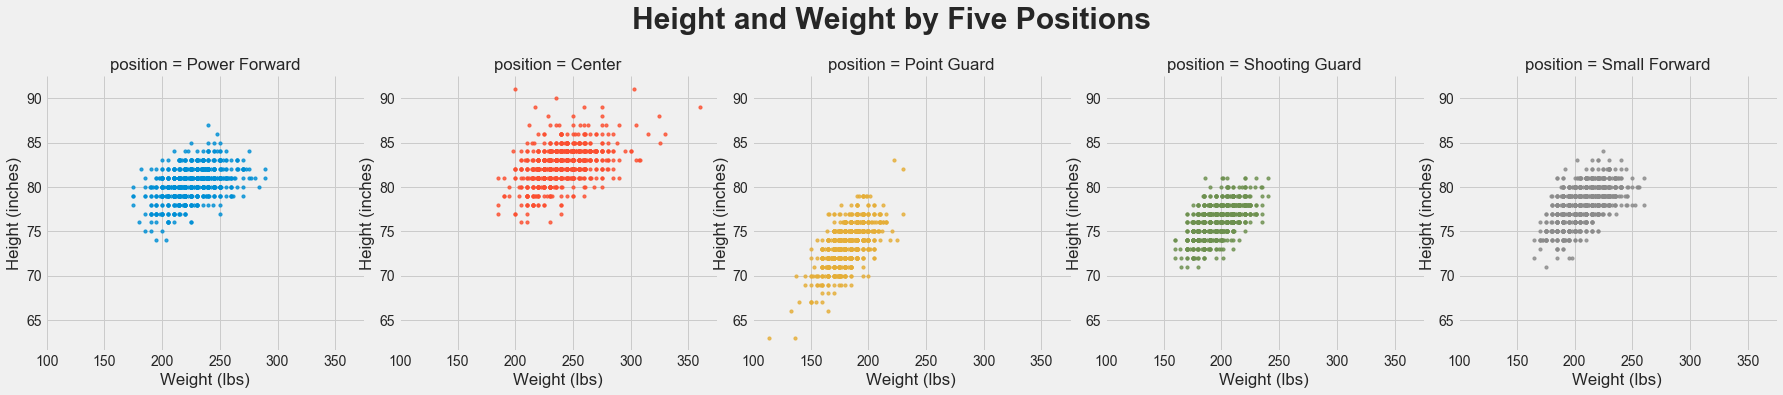

In [9]:
plt.style.use('fivethirtyeight')

ax = sns.lmplot(x="weight", y="height_inches", data=players, 
               col='position', hue='position',
               x_jitter=.1, fit_reg=False, scatter_kws={"s": 10})

ax.set(xlabel='Weight (lbs)', ylabel='Height (inches)')

hw_subtitle = plt.suptitle('Height and Weight by Five Positions', fontsize=30, fontweight="bold", y=1.1)

plt.savefig('all-graphs/height_weight_5pos.png', bbox_inches='tight',bbox_extra_artists=[hw_subtitle])

In [15]:
players.groupby('position').count()['trad_position'].sort_values()

position
Center             790
Power Forward      845
Shooting Guard     918
Point Guard        939
Small Forward     1037
Name: trad_position, dtype: int64

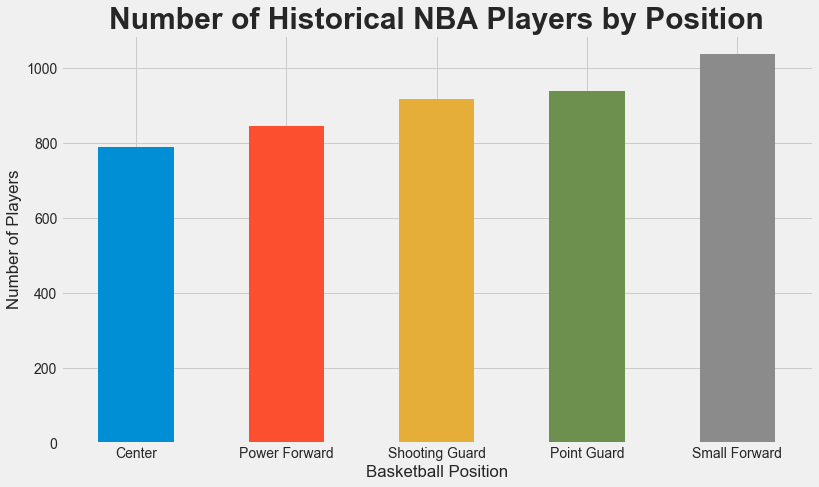

In [16]:
plt.style.use('fivethirtyeight')

ax = players.groupby('position').count()['trad_position'].sort_values().plot.bar(figsize=(12,7), rot=0)
ax.set(xlabel='Basketball Position', ylabel='Number of Players')

plt.title('Number of Historical NBA Players by Position', fontsize=30, fontweight="bold")

plt.savefig('all-graphs/num_pos.png')

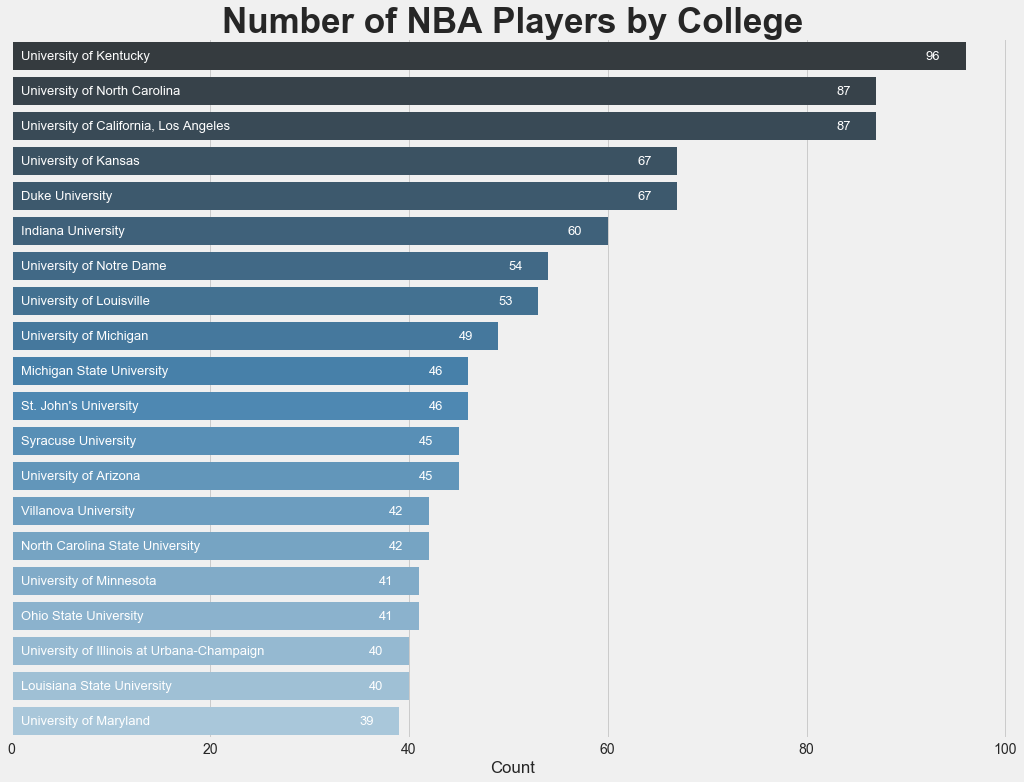

In [17]:
plt.style.use('fivethirtyeight')

top_colleges = players['college'].value_counts()[:20]
top_colleges_df = pd.DataFrame(top_colleges)
top_colleges_df.columns = ['Count']

plt.figure(figsize=(16,12))
sns.barplot(x='Count', y=top_colleges_df.index, data=top_colleges_df, palette="Blues_d")
plt.title('Number of NBA Players by College', fontsize=35, fontweight='bold')
plt.gca().set_yticks([]);

for num in range(len(top_colleges)):
    plt.text(top_colleges[num]-4, num, top_colleges[num], color='white', size=13, verticalalignment='center')
    plt.text(1, num, top_colleges.index[num], color='white', size=13, verticalalignment='center')
    
plt.savefig('all-graphs/top_colleges.png')

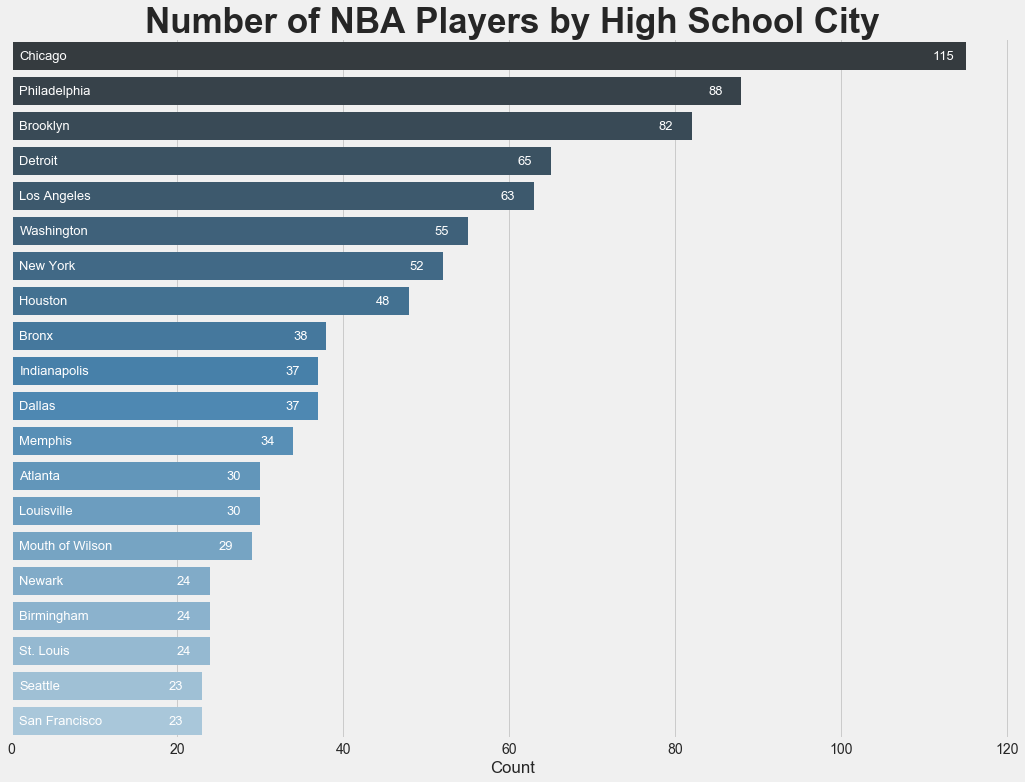

In [18]:
plt.style.use('fivethirtyeight')

top_hs_cities = players['hs_city'].value_counts()[:20]
top_hs_cities_df = pd.DataFrame(top_hs_cities)
top_hs_cities_df.columns = ['Count']

plt.figure(figsize=(16,12))
sns.barplot(x='Count', y=top_hs_cities_df.index, data=top_hs_cities_df, palette="Blues_d")
plt.title('Number of NBA Players by High School City', fontsize=35, fontweight="bold")
plt.gca().set_yticks([]);

for num in range(len(top_hs_cities)):
    plt.text(top_hs_cities[num]-4, num, top_hs_cities[num], color='white', size=13, verticalalignment='center')
    plt.text(1, num, top_hs_cities.index[num], color='white', size=13, verticalalignment='center')
    
plt.savefig('all-graphs/top_hs_city.png')

## Model data for Machine Learning regression

In [16]:
players_feat = players[['career_length', 'position', 'trad_position', 
                        'ppg', 'trb', 'ast', 'fgp', 'per', 'ws', 'height_inches', 'weight', 'hof']].copy()
players_feat.head()

,career_length,position,trad_position,ppg,trb,ast,fgp,per,ws,height_inches,weight,hof
0,4,Power Forward,Forward,5.7,3.3,0.3,50.2,13.0,4.8,82.0,240.0,0.0
1,9,Power Forward,Forward,9.0,8.0,1.2,42.8,15.1,17.5,81.0,235.0,0.0
2,19,Center,Center,24.6,11.2,3.6,55.9,24.6,273.4,86.0,225.0,1.0
3,10,Point Guard,Guard,14.6,1.9,3.5,44.2,15.4,25.2,73.0,162.0,0.0
4,5,Shooting Guard,Guard,7.8,3.3,1.1,41.7,11.4,3.5,78.0,223.0,0.0


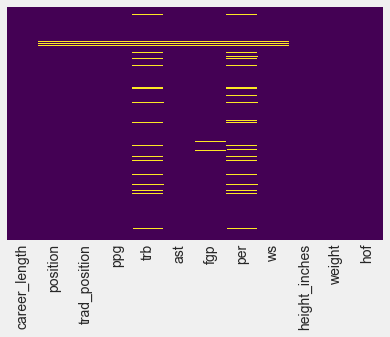

In [17]:
sns.heatmap(players_feat.isnull(), yticklabels=False, cbar=False, cmap='viridis')

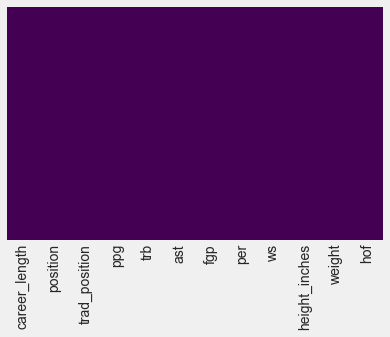

In [18]:
players_feat = players_feat.dropna() # delete rows with NaN values
sns.heatmap(players_feat.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## Model data for Machine Learning regression

### Modern Five Positions

In [73]:
from sklearn.model_selection import train_test_split

X = players_feat[['career_length', 'ppg', 'trb', 'ast', 'fgp', 'per', 'ws', 'height_inches', 'weight']]
y = players_feat['position']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Logistic Regression Model</font>

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score


logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))   

                precision    recall  f1-score   support

        Center       0.56      0.69      0.62       219
   Point Guard       0.71      0.76      0.74       251
 Power Forward       0.39      0.28      0.33       225
Shooting Guard       0.61      0.57      0.59       284
 Small Forward       0.49      0.51      0.50       269

   avg / total       0.56      0.57      0.56      1248



[[152   0  43   0  24]
 [  0 192   1  53   5]
 [ 91   0  64   0  70]
 [  0  69  11 162  42]
 [ 28   9  46  49 137]]


accuracy Score:  0.5665064102564102


<font color='blue'>Decision Tree Classifier</font>

In [31]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))   

                precision    recall  f1-score   support

        Center       0.64      0.60      0.62       219
   Point Guard       0.69      0.69      0.69       251
 Power Forward       0.44      0.48      0.46       225
Shooting Guard       0.51      0.52      0.52       284
 Small Forward       0.48      0.45      0.47       269

   avg / total       0.55      0.55      0.55      1248



[[131   2  77   1   8]
 [  1 173   0  69   8]
 [ 55   0 109   8  53]
 [  0  67   6 148  63]
 [ 18   8  57  64 122]]


accuracy Score:  0.5472756410256411


<font color='blue'>Naive Bayse Classifier</font>

In [32]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))  

                precision    recall  f1-score   support

        Center       0.79      0.65      0.71       219
   Point Guard       0.74      0.70      0.72       251
 Power Forward       0.51      0.62      0.56       225
Shooting Guard       0.59      0.56      0.57       284
 Small Forward       0.57      0.61      0.59       269

   avg / total       0.64      0.62      0.63      1248



[[142   0  71   0   6]
 [  0 176   0  71   4]
 [ 34   0 140   0  51]
 [  0  59   5 159  61]
 [  4   3  58  41 163]]


accuracy Score:  0.625


<font color='blue'>Support Vector Machine Classifier</font>

In [33]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)
predictions = svc_model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))  

                precision    recall  f1-score   support

        Center       0.58      0.22      0.32       219
   Point Guard       0.59      0.30      0.40       251
 Power Forward       0.25      0.57      0.35       225
Shooting Guard       0.52      0.41      0.46       284
 Small Forward       0.43      0.47      0.45       269

   avg / total       0.47      0.40      0.40      1248



[[ 49   0 157   0  13]
 [  0  75  91  68  17]
 [ 32   0 128   3  62]
 [  0  44  47 116  77]
 [  4   8  94  37 126]]


accuracy Score:  0.3958333333333333


### Traditional Three Positions

In [34]:
X = players_feat[['ppg', 'trb', 'ast', 'height_inches', 'weight']]
y = players_feat['trad_position']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Logistic Regression Model</font>

In [35]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

     Center       0.68      0.33      0.45       215
    Forward       0.67      0.80      0.73       500
      Guard       0.87      0.89      0.88       533

avg / total       0.76      0.76      0.75      1248



[[ 72 140   3]
 [ 34 399  67]
 [  0  56 477]]


<font color='blue'>Decision Tree Classifier</font>

In [36]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

     Center       0.66      0.65      0.65       215
    Forward       0.71      0.72      0.71       500
      Guard       0.87      0.86      0.87       533

avg / total       0.77      0.77      0.77      1248



[[139  76   0]
 [ 73 358  69]
 [  0  72 461]]


<font color='blue'>Naive Bayse Classifier</font>

In [37]:
model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

     Center       0.72      0.70      0.71       215
    Forward       0.74      0.77      0.75       500
      Guard       0.89      0.86      0.88       533

avg / total       0.80      0.80      0.80      1248



[[150  65   0]
 [ 58 384  58]
 [  0  72 461]]


<font color='blue'>Support Vector Machine Classifier</font>

In [38]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)
predictions = svc_model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))  

             precision    recall  f1-score   support

     Center       0.72      0.52      0.61       215
    Forward       0.69      0.79      0.74       500
      Guard       0.88      0.85      0.87       533

avg / total       0.78      0.77      0.77      1248



[[112 103   0]
 [ 43 396  61]
 [  0  78 455]]


accuracy Score:  0.7716346153846154


### Year-by-year statistics

In [55]:
left_hand = []
right_hand = []
height = []
weight = []
ppg = []
trb = []
ast = []


start = players.active_from.min() # 1947 Season
end = players.active_from.max() # 2018 Season

for year in range(start,end):
    active = (players.active_from.values <= year) & (players.active_to >= year) # only include active players
    height.append(np.mean(players[active].height_inches)) # average height in inches
    weight.append(np.mean(players[active].weight)) # average weight in pounds
    left_hand.append(1.0*np.sum(players[active].shooting_hand == 'Left')) # number of left handed shooters
    right_hand.append(1.0*np.sum(players[active].shooting_hand == 'Right')) # number of right handed shooters
    ppg.append(np.mean(players[active].ppg))
    trb.append(np.mean(players[active].trb))
    ast.append(np.mean(players[active].ast))
    
# create a DataFrame with a summary
stats_year = pd.DataFrame({'season': np.arange(start,end), 
                          'height': height,
                          'weight': weight,
                          'left_hand': left_hand,
                          'right_hand': right_hand,
                          'ppg': ppg,
                          'trb': trb,
                          'ast': ast}).set_index('season')

# preview
stats_year.head()

,ast,height,left_hand,ppg,right_hand,trb,weight
season,,,,,,,
1947,0.748125,74.322981,4.0,5.051250,156.0,3.791304,188.656250
1948,1.157018,74.570175,2.0,6.642982,112.0,3.671875,187.362832
1949,1.400565,75.197740,6.0,6.537288,171.0,3.974603,191.536723
1950,1.728125,75.324444,5.0,7.046875,219.0,4.036066,191.493274
1951,1.932450,75.843137,6.0,8.190728,145.0,3.970199,194.549020


The per-season figures reflect the average statistical value for players who were active that year. It assumes that every player had a consistent height and weight for their entire careers, which is unlikely since players tend to be shortest/lightest their rookie years. It also assumes that players did not switch their shooting hands during their careers.

We can get more detailed season averages on [this page](http://en.wikipedia.org "Basketball Reference"), but for the purpose of this exercise we will use career averages for players active in each season

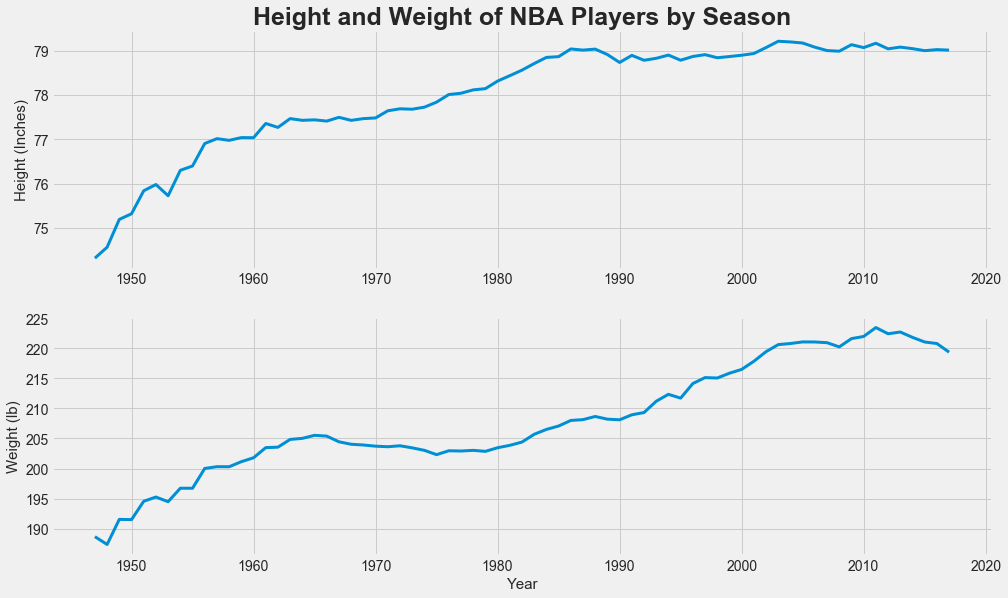

In [56]:
plt.style.use('fivethirtyeight')

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15,9))

plt.subplot(2, 1, 1)
plt.title('Height and Weight of NBA Players by Season', fontsize = 25, fontweight='bold')
plt.plot(stats_year['height'], linewidth=3.0)
plt.ylabel("Height (Inches)", fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(stats_year['weight'], linewidth=3.0)
plt.ylabel('Weight (lb)', fontsize=15)
plt.xlabel('Year', fontsize=15)

plt.savefig('all-graphs/yoy_weight_weight.png')

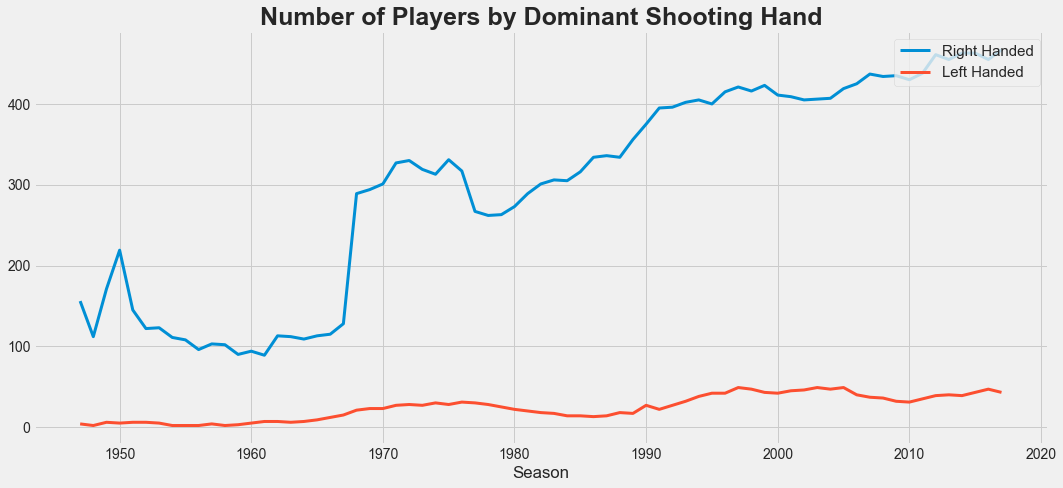

In [57]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,7))

stats_year['right_hand'].plot(figsize=(15,7), label='Right Handed', linewidth=3.0)
stats_year['left_hand'].plot(label='Left Handed', linewidth=3.0)

plt.legend(loc=1, frameon=True, prop={'size': 15})
plt.xlabel("Season")
plt.title('Number of Players by Dominant Shooting Hand', fontsize = 25, fontweight='bold')

plt.tight_layout()

plt.savefig('all-graphs/yoy_left_right.png')

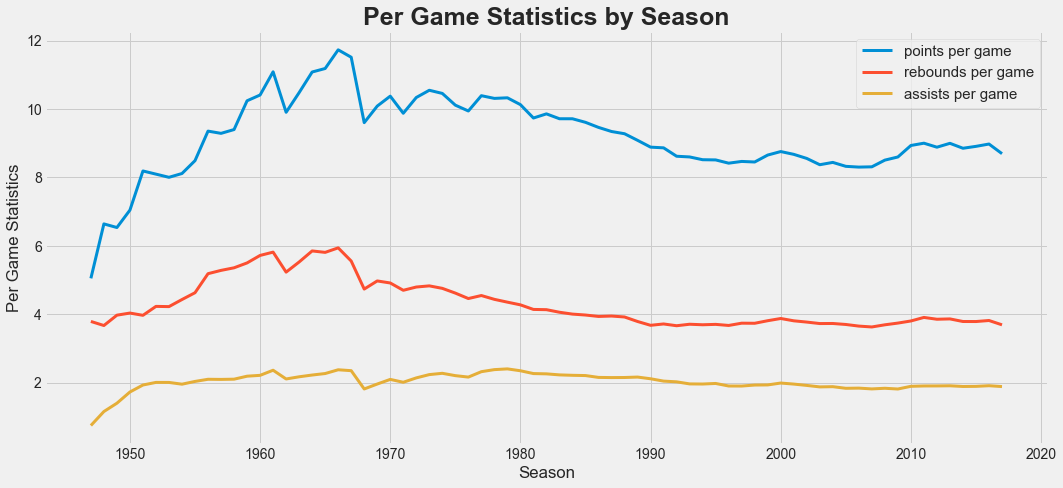

In [58]:
plt.style.use('fivethirtyeight')

stats_year['ppg'].plot(figsize=(15,7), label='points per game', linewidth=3.0)
stats_year['trb'].plot(label='rebounds per game', linewidth=3.0)
stats_year['ast'].plot(label='assists per game', linewidth=3.0)

plt.legend(loc=1, frameon=True, prop={'size': 15})
plt.xlabel("Season")
plt.ylabel("Per Game Statistics")
plt.title('Per Game Statistics by Season', fontsize = 25, fontweight='bold')

plt.tight_layout()

plt.savefig('all-graphs/yoy_ppg_trb_ast.png')

### Predicting Height by year

In [59]:
X = stats_year.drop('height', axis=1)
y = stats_year['height']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Linear Regression Model</font>

In [60]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

print("R2 Score: ", lm.score(X_test, y_test))

R2 Score:  0.9284532767065335


In [61]:
predictions

array([78.75959166, 77.27957928, 78.66067058, 79.51767812, 77.5538923 ,
       79.24649062, 78.21382731, 77.92877683, 77.25265276, 78.68003689,
       77.69609023, 79.54317451, 78.39950754, 76.91275709, 79.3213917 ,
       78.68514146, 76.41194164, 76.6874756 , 79.60764408, 76.02314918,
       77.40425522, 78.92916423])

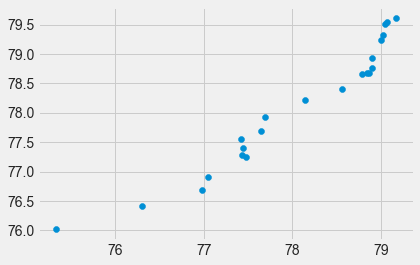

In [62]:
plt.scatter(y_test, predictions) ## y_test contains the contain ppg averages year-by-year

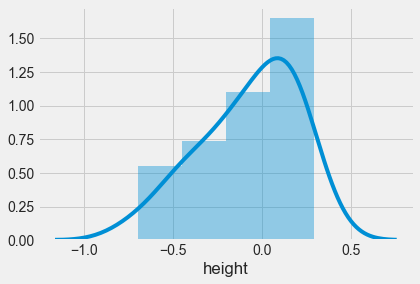

In [63]:
sns.distplot(y_test - predictions) # histogram of the residuals